In [1]:
import os
import sys
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import random
import time

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
pretrained = "twitter.27B.50d"

In [6]:
name = ".".join(pretrained.split('.')[:2])
dim = int(pretrained.split('.')[-1].replace('d',''))

In [7]:
sys.path.append('..')
from datasets import imdb as dataset
import TextCNN.models.textcnn as textcnn

In [8]:
from vae import *

In [9]:
dataset_name = 'rt'

In [10]:
if dataset_name == 'imdb':
    dataset_root = '/ksozykinraid/data/nlp/IMDB/'
    dataset.split_train_valid(path_data='{}/imdb.csv'.format(dataset_root))
    pth = torch.load('{}/imdb_text_cnn_best_twitter27b50d.pth'.format(dataset_root),map_location='cpu')
elif dataset_name == 'rt':
    dataset_root = '/ksozykinraid/data/nlp/rt-polaritydata/'
    dataset.split_train_valid(path_data='{}/rt-polarity.csv'.format(dataset_root))
    pth = torch.load('{}/rt-polarity_twitter.27B.50d_text_cnn_best.pth'.format(dataset_root),map_location='cpu')

Spliting original file to train/valid set...


In [11]:
fix_length=32
batch_size = 64

In [12]:
dataset = dataset.IMDB_Dataset(pretrained=pretrained,fix_length=fix_length,mbsize=batch_size)

Preprocessing the text...


The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [13]:
V = dataset.TEXT.vocab

In [14]:
target = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
target.load_state_dict(pth['state_dict'])
target.embed = feedEmbed(target.embed )
device='cuda'
target = target.to(device)

In [15]:
device='cuda'
disc = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
disc.embed = target.embed 
disc = disc.to(device)

In [16]:
disable_all_grads(target)

In [17]:
if not os.path.exists('pth/'):
    os.makedirs('pth/')
if not os.path.exists('pth_re_train/'):
    os.makedirs('pth_re_train/')


In [18]:
itos = dataset.LABEL.vocab.itos

In [19]:
h_dim = 32
lr = 1e-2
lr_decay_every = 1000

In [20]:
dataset.n_train_batch

133

In [21]:
model = RNN_VAE(
    dataset.n_vocab, h_dim,h_dim,2, p_word_dropout=0.3,
    pretrained_embeddings=dataset.get_vocab_vectors(), freeze_embeddings=False,max_sent_len=fix_length,
    gpu=True
)

In [22]:
def batch_itos(x):
    return [" ".join([V.itos[e] for e in s]) for s in x]

In [23]:
def perplexity(p):
    # [seq_len,probs]
    # per 1 elem in batch
    # as in paper
    with torch.no_grad():
        #ppl = -torch.log(F.softmax(p,-1)).sum(1).sum(0)/len(V)
        ppl = -F.log_softmax(p,-1).sum(1).sum(0)/len(V)
        return ppl.cpu().numpy()

In [24]:
def save_model(re_train,model,disc,phi):
    pth = {}
    pth['state_dict'] = model.state_dict()
    pth['disc_state_dict'] = disc.state_dict()
    root = './pth' if not re_train else './pth_re_train'
    torch.save(pth, '{}/vae_phi{}.pth'.format(root,phi))

In [25]:
def test_attack_rate(N):
    j = 0
    rate = []
    perp = []
    for _ in range(N):
        z = model.sample_z_prior(1)
        c = model.sample_c_prior(1)
        z=torch.cat([z,model.C[torch.argmax(c)].unsqueeze(0)],-1)


        sample_idxs,sample_logits = model.sample_sentence(z, c)
        sample_sent = dataset.idxs2sentence(sample_idxs)
        ppl = perplexity(sample_logits)
        sample_logits = sample_logits.unsqueeze(0)


        if sample_logits.shape[1] < 5:
            continue
        j += 1
        if j >= N:
            break
        c_idx = torch.argmax(c,-1).cpu().numpy()[0]
        pred_label_idx =  torch.argmax(target(sample_logits),-1)[0].cpu().numpy()
        rate.append(c_idx !=  pred_label_idx)
        perp.append(ppl)
    perp = np.mean(ppl)
    attack_rate=np.mean(rate)
    return attack_rate,perp

In [26]:
with_disriminator = True
from_scratch = False # do we used checkpoints or not
generate_and_save = False # used for re-training on adversarial data
tune_on_z  = False # used for re-training on adversarial data

In [27]:
beta1 = 0.9

In [28]:

def train(phi = 0,
          num_epochs=5,
          log_interval = 10,
          re_train=False,
          gen_batch_size=8):
    vanila = (phi == 0)
    print("phi={}".format(phi))
    n_iter = num_epochs*dataset.n_train_batch
    # Annealing for KL term
    kld_start_inc = 1000
    kld_weight = 0.0
    kld_max = 1
    if not vanila:
        kld_weight =  kld_max
    kld_inc = (kld_max - kld_weight) / (n_iter - kld_start_inc)
    it = 0
    loss_data = []
    recon_loss_data = []
    kl_loss_data = []
    opt = optim.Adam(model.vae_params + list(target.parameters()), lr=lr,betas=(beta1, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=lr,betas=(beta1, 0.999))
    for epoch in range(num_epochs):
      #print("epoch",epoch)
      for idx,batch in enumerate(dataset.train_iter):
            x, labels = batch.text, batch.label
            c  = torch.eye(2)[labels]
            x, labels = x.to(device), labels.to(device)
            c = c.to(device)

            recon_loss, kl_loss, x_hat = model.forward(x,c)
            loss = recon_loss + kld_weight * kl_loss


            #Anneal kl_weight
            if it > kld_start_inc and kld_weight < kld_max:
                kld_weight += kld_inc

            loss = loss.reshape(1)
            attack_rate = 0

            if not vanila:
                x_adv, labels_adv = model.generate_sentences(gen_batch_size)
                pred_adv = target(x_adv)
                Ladv = F.cross_entropy(pred_adv,torch.argmax(labels_adv.long(),-1))

                labels_adv_idx =  torch.argmax(labels_adv.long(),-1).cpu().numpy()
                pred_label_idx =  torch.argmax(pred_adv,-1).cpu().numpy()

                attack_rate=np.mean((labels_adv_idx !=  pred_label_idx))
                
                loss -= phi*Ladv
                
                if with_disriminator:
                    x_real = torch.eye(len(V))[x].to(device)
                    x_real = torch.transpose(x_real,0, 1)
                    pred_real = disc(x_real)
                    Ldisc_real = F.cross_entropy(pred_real,labels)
                    Ldisc_real.backward()
                    #https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
                    pred_fake = disc(x_adv.detach())
                    Ldisc_fake = F.cross_entropy(pred_fake,torch.argmax(labels_adv.long(),-1))
                    Ldisc_fake.backward()

                    Ldisc = Ldisc_real + Ldisc_fake
                    grad_norm = torch.nn.utils.clip_grad_norm(disc.parameters(), 1)
                    opt_disc.step()
                    opt_disc.zero_grad()

                
                #print('loss',loss.data)

            loss.backward()
            #grad_norm = torch.nn.utils.clip_grad_norm(model.vae_params, 1)
            opt.step()
            opt.zero_grad()

            loss_data.append(loss.data)
            recon_loss_data.append(recon_loss.reshape(1).data)
            kl_loss_data.append(kl_loss.reshape(1).data)


            if it % log_interval == 0:

                save_model(re_train,model,disc,phi)
                x_text = batch_itos(x)
                x_text_hat = batch_itos(torch.argmax(x_hat,-1))

                z = model.sample_z_prior(1)
                c = model.sample_c_prior(1)
                z=torch.cat([z,model.C[torch.argmax(c)].unsqueeze(0)],-1)

                sample_idxs,sample_logits = model.sample_sentence(z, c)
                sample_sent = dataset.idxs2sentence(sample_idxs)

                sample_logits = sample_logits.unsqueeze(0)


                if sample_logits.shape[1] < 5:
                    continue



                pred_label_idx =  torch.argmax(target(sample_logits),-1)[0]


                c_idx = torch.argmax(c)
                print('epoch-%d Iter-%d; Loss: %9.4f; Recon: %9.4f; KL: %9.4f;'%(epoch,it, loss.data, 
                                                                                 recon_loss.data, kl_loss.data))
                print(sample_sent)
                print('sampled',itos[c_idx],'predicted',itos[pred_label_idx])
                print('attack_rate per batch',attack_rate)
                print('perplexity per sampled sentance',perplexity(sample_logits[0]))
                print()
            # Anneal learning rate
            #new_lr = lr * (0.5 ** (it // lr_decay_every))
            #for param_group in opt.param_groups:
            #    param_group['lr'] = new_lr
            it += 1
    
    return loss_data,recon_loss_data, kl_loss_data 

In [29]:
log_interval =  1000

In [30]:
if from_scratch:
    loss_data,recon_loss_data, kl_loss_data = train(phi=0,num_epochs=250,log_interval = log_interval)
    a,ppl = test_attack_rate(500)
    print(a)


In [31]:
if from_scratch:
    LD = []
    RLD = []
    KLD = []
    for i in range(0, len(loss_data)):
        LD.append(loss_data[i].data.cpu().numpy()[0])
        RLD.append(recon_loss_data[i].data.cpu().numpy()[0])
        KLD.append(kl_loss_data[i].data.cpu().numpy()[0])


    plt.figure(facecolor='white')
    plt.plot(LD, marker='o',label='LD')
    plt.plot(RLD, marker='o',label='RLD')
    plt.plot(KLD, marker='o',label='KLD')
    plt.grid()
    plt.legend()

In [32]:
if from_scratch:
    phis=[1,3,6,9]
    for phi in phis:
        vae_phi0_pth = torch.load('./pth/vae_phi0.pth',map_location='cpu')
        try:
            model.load_state_dict(vae_phi0_pth['state_dict'])
        except:
            pass
        log_interval = 100
        num_epochs = 3
        loss_data,recon_loss_data, kl_loss_data = train(phi=phi,num_epochs=num_epochs,log_interval = log_interval)
        a,ppl = test_attack_rate(500)
        print('test attack rate',a)
        print('test ppl',ppl)
        #attack_rates_test.append(a)

In [33]:
def get_metrics(root='./pth',phis=[0,1,3,6,9]):
    at = []
    perp = []
    for phi in phis:
        print(phi)
        vae_phi0_pth = torch.load('{}/vae_phi{}.pth'.format(root,phi),map_location='cpu')
        try:
            model.load_state_dict(vae_phi0_pth['state_dict'])
            model.eval()
        except:
            pass
        a,ppl = test_attack_rate(500)
        print('test attack rate',a)
        print('test ppl',ppl)
        perp.append(ppl)
        at.append(a)
    model.train()
    return phis,at,perp

In [34]:
phis0,at0,perp0 = get_metrics()

0
test attack rate 0.18951612903225806
test ppl 311.17212
1
test attack rate 0.7775551102204409
test ppl 1274.8713
3
test attack rate 0.7214428857715431
test ppl 481.82004
6
test attack rate 0.6953907815631263
test ppl 1571.7367
9
test attack rate 0.9779559118236473
test ppl 1855.4551


In [35]:
def plot_plots(phis_,at_,perp_):
    print('phis:',phis_)
    print('attack_rates:',at_)
    print('ppl:',perp_)
    plt.figure(facecolor='white',figsize=(20,20))
    plt.subplot(2,1,1)
    plt.plot(phis_,at_,marker='o',color='red')
    plt.grid()
    plt.xlabel("phi")
    plt.ylabel("attack rate")
    plt.ylim(0)
    plt.subplot(2,1,2)
    plt.plot(phis_,perp_,marker='o',color='g')
    plt.grid()
    plt.xlabel("phi")
    plt.ylabel("ppl")
    plt.ylim(0)

phis: [0, 1, 3, 6, 9]
attack_rates: [0.18951612903225806, 0.7775551102204409, 0.7214428857715431, 0.6953907815631263, 0.9779559118236473]
ppl: [311.17212, 1274.8713, 481.82004, 1571.7367, 1855.4551]


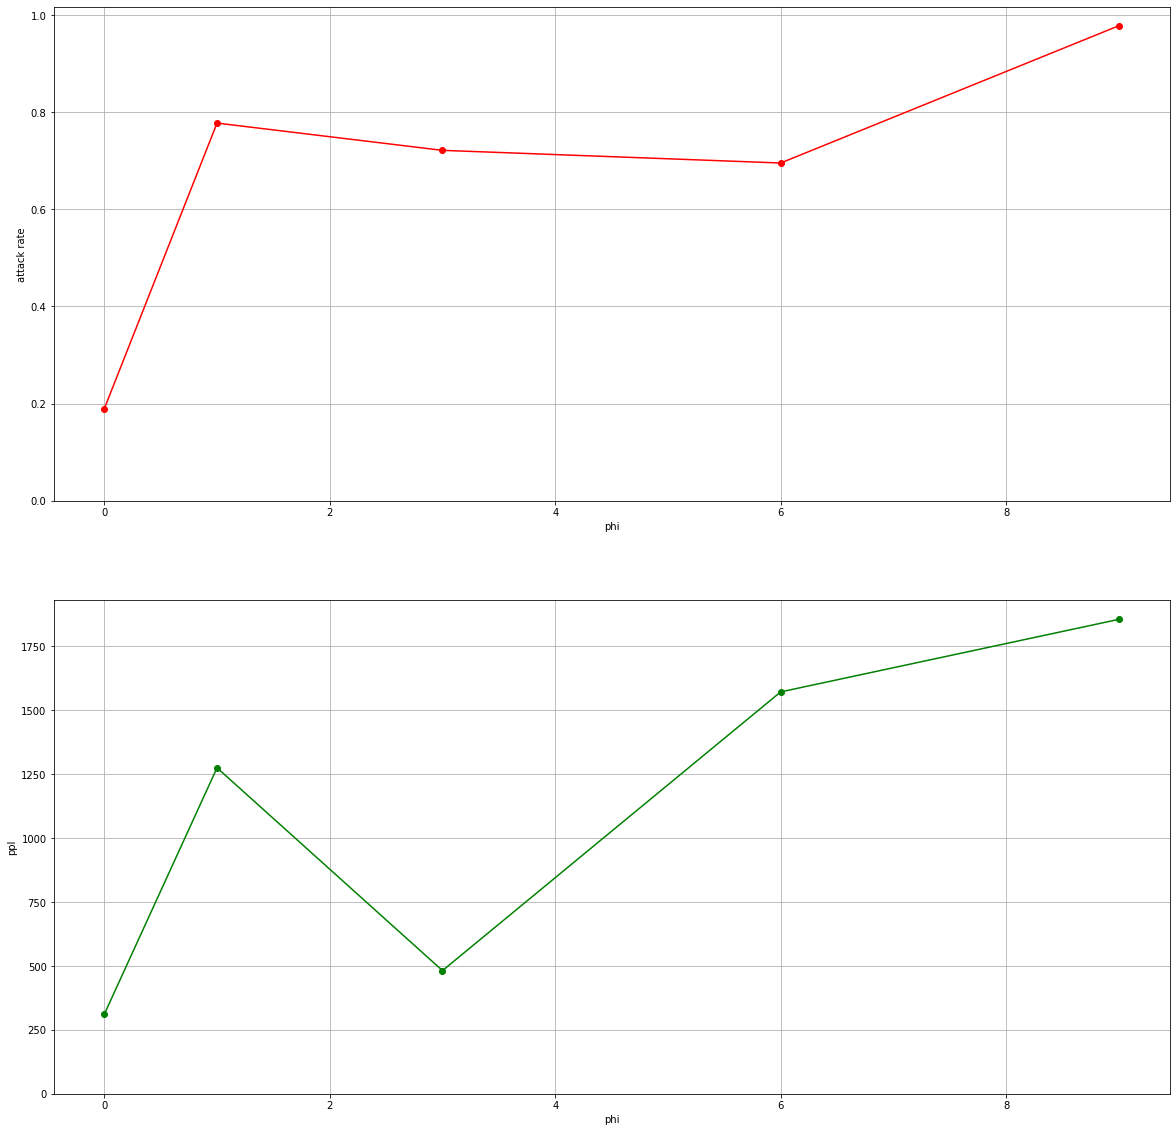

In [36]:
plot_plots(phis0,at0,perp0)

## Samples for validity rate

In [37]:
samples = []

In [38]:
phis=[0,1,3,6,9]
for phi in phis:
    vae_phi_pth = torch.load('./pth/vae_phi{}.pth'.format(phi),map_location='cpu')
    try:
        model.load_state_dict(vae_phi_pth['state_dict'])
    except:
        pass
    for i in range(batch_size):
        z = model.sample_z_prior(1)
        c = model.sample_c_prior(1)
        z=torch.cat([z,model.C[torch.argmax(c)].unsqueeze(0)],-1)

        sample_idxs,sample_logits = model.sample_sentence(z, c)
        sample_sent = dataset.idxs2sentence(sample_idxs)
        lb = torch.argmax(c)
        sample_label = itos[lb]
        samples.append([phi,sample_sent,sample_label])

In [39]:
samples = pd.DataFrame(samples)
samples.columns = ['phi','sample_sent','sample_label',]

In [40]:
samples.to_csv('validity_rate_sample.csv',index=None)

In [41]:
samples.head()

,phi,sample_sent,sample_label
0,0,the film 's a toy chest contents off,negative
1,0,the film is weighed down by the third charms a...,negative
2,0,the film is a needlessly opaque intro takes it...,negative
3,0,"the film 's sopranos , breast and flatulence g...",negative
4,0,a simmering psychological drama about the dram...,positive


## Re-training

In [42]:

N_adv = 6000//batch_size
from tqdm import tqdm
if generate_and_save:
    vae_phi9_pth = torch.load('./pth/vae_phi9.pth'.format(),map_location='cpu')
    try:
        model.load_state_dict(vae_phi9_pth['state_dict'])
    except:
        pass
    X_adv = []
    L_adv = []
    for i in tqdm(range(N_adv)):
        with torch.no_grad():
            x_adv, labels_adv = model.generate_sentences(batch_size)
            x_adv, labels_adv = x_adv.cpu(), labels_adv.cpu()
            X_adv.append(x_adv)
            L_adv.append(labels_adv)
    adv_data = {}
    adv_data['x'] = X_adv
    adv_data['l'] = L_adv 
    torch.save(adv_data, './adv_data.pth')


In [43]:

if tune_on_z:
    print('re-training')
    target = textcnn.textCNN(V, 100, [3,4,5], 0.5 , 2)
    target.load_state_dict(pth['state_dict'])
    target.embed = feedEmbed(target.embed )
    target = target.to(device)
    enable_all_grads(target)
    optimizer = optim.Adam(target.parameters(), lr=1e-3)
    total_loss = []
    total_attack = []
    it = 0
    for epoch in range(9):
        num_uncorrect = 0
        num_samples = 0
        for x_adv,l_adv in zip(adv_data['x'],adv_data['l']):
            x_adv,l_adv = x_adv.cuda(),l_adv.cuda()
            optimizer.zero_grad()
            pred_adv = target(x_adv)

            Ladv = F.cross_entropy(pred_adv,torch.argmax(l_adv.long(),-1))
            Ladv.backward()
            total_loss.append(Ladv.data.cpu().numpy())
            if it % 100 == 0:
                print(total_loss[-1])
            optimizer.step()
            it += 1
            c_idx = torch.argmax(l_adv,-1).cpu().numpy()
            pred =  torch.argmax(pred_adv,-1).cpu().numpy()
            num_uncorrect += (pred != c_idx).sum()
            num_samples += len(c_idx) 
        a = num_uncorrect/num_samples
        total_attack.append(a)
        print('epoch',epoch,a)
    disable_all_grads(target)

In [44]:
from_scratch_re_train = False

In [45]:
if from_scratch_re_train:
    phis=[1,3,6,9]
    for phi in phis:
        vae_phi0_pth = torch.load('./pth/vae_phi9.pth',map_location='cpu')
        try:
            model.load_state_dict(vae_phi0_pth['state_dict'])
        except:
            pass
        log_interval = 100
        num_epochs = 2
        loss_data,recon_loss_data, kl_loss_data = train(phi=phi,num_epochs=num_epochs,
                                                        log_interval = log_interval,re_train=True)
        a,ppl = test_attack_rate(100)
        print('test attack rate',a)
        print('test ppl',ppl)
        #attack_rates_test.append(a)

In [46]:
!cp ./pth/vae_phi0.pth ./pth_re_train/

In [47]:
phis1,at1,perp1 = get_metrics(root='./pth_re_train')

0
test attack rate 0.17682926829268292
test ppl 317.96317
1
test attack rate 0.3231707317073171
test ppl 511.8354
3
test attack rate 0.5951903807615231
test ppl 1021.5484
6
test attack rate 0.44889779559118237
test ppl 1104.0319
9
test attack rate 0.46893787575150303
test ppl 962.2538


phis: [0, 1, 3, 6, 9]
attack_rates: [0.17682926829268292, 0.3231707317073171, 0.5951903807615231, 0.44889779559118237, 0.46893787575150303]
ppl: [317.96317, 511.8354, 1021.5484, 1104.0319, 962.2538]


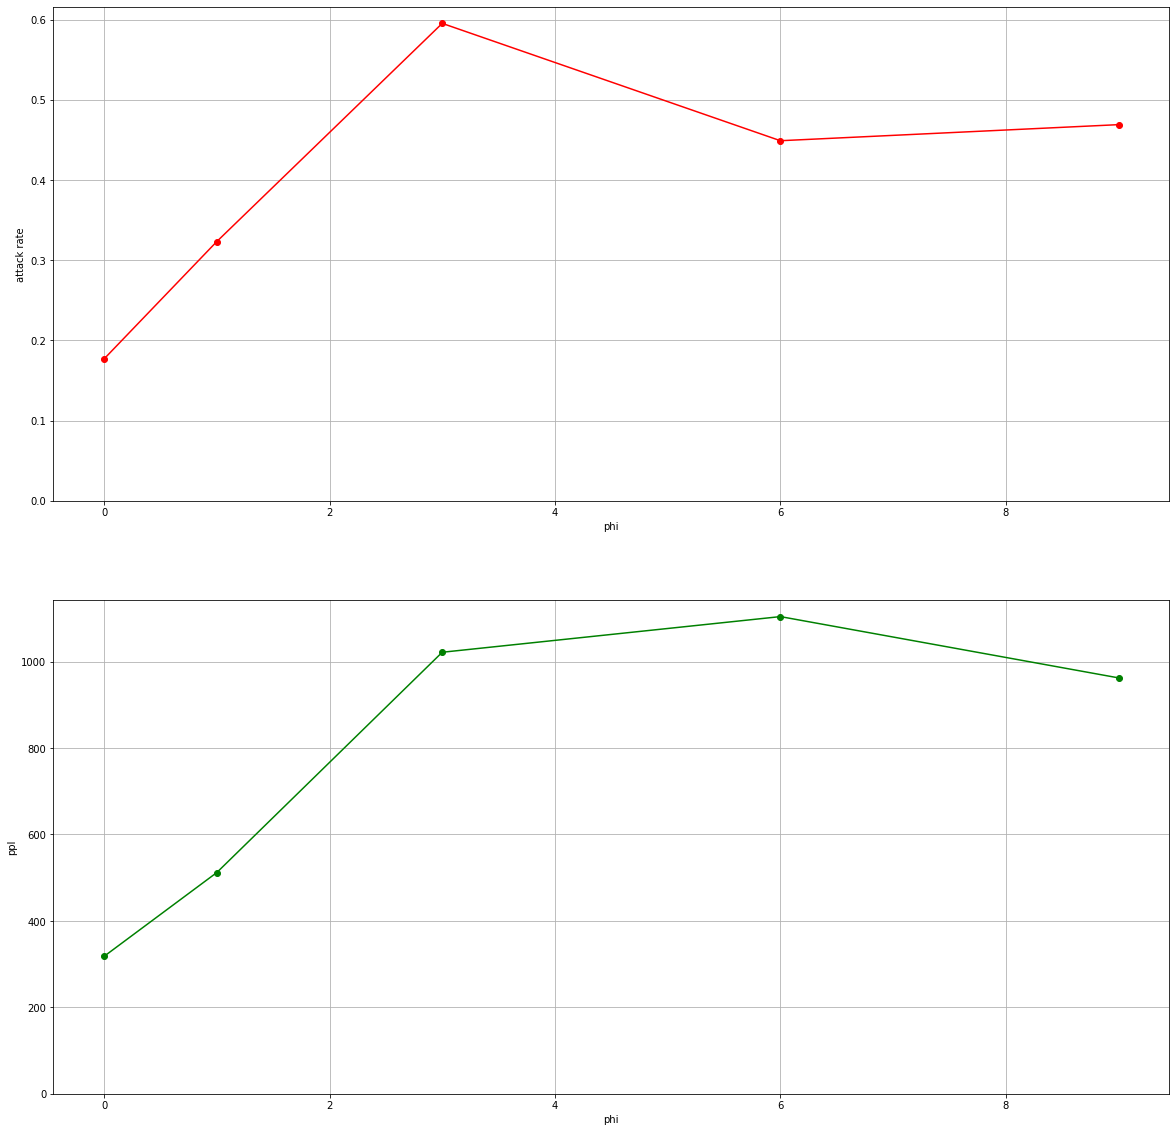

In [48]:
plot_plots(phis1,at1,perp1)

In [49]:
def plot_comp_plots(phis0,at0,perp0,phis1,at1,perp1):
    print('phis:',phis0)
    print('attack_rates:',at0)
    print('ppl:',perp0)
    print('phis:',phis1)
    print('attack_rates:',at1)
    print('ppl:',perp1)
    plt.figure(facecolor='white',figsize=(20,20))
    plt.subplot(2,1,1)
    plt.plot(phis0,at0,marker='o',color='red',label='before')
    plt.plot(phis1,at1,marker='o',color='blue',label='after')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel("phi")
    plt.ylabel("attack rate")
    plt.ylim(0)
    plt.subplot(2,1,2)
    plt.plot(phis0,perp0,marker='o',color='red',label='before')
    plt.plot(phis1,perp1,marker='o',color='blue',label='after')
    plt.grid()
    plt.legend(loc='best')
    plt.xlabel("phi")
    plt.ylabel("ppl")
    plt.ylim(0)

phis: [0, 1, 3, 6, 9]
attack_rates: [0.18951612903225806, 0.7775551102204409, 0.7214428857715431, 0.6953907815631263, 0.9779559118236473]
ppl: [311.17212, 1274.8713, 481.82004, 1571.7367, 1855.4551]
phis: [0, 1, 3, 6, 9]
attack_rates: [0.17682926829268292, 0.3231707317073171, 0.5951903807615231, 0.44889779559118237, 0.46893787575150303]
ppl: [317.96317, 511.8354, 1021.5484, 1104.0319, 962.2538]


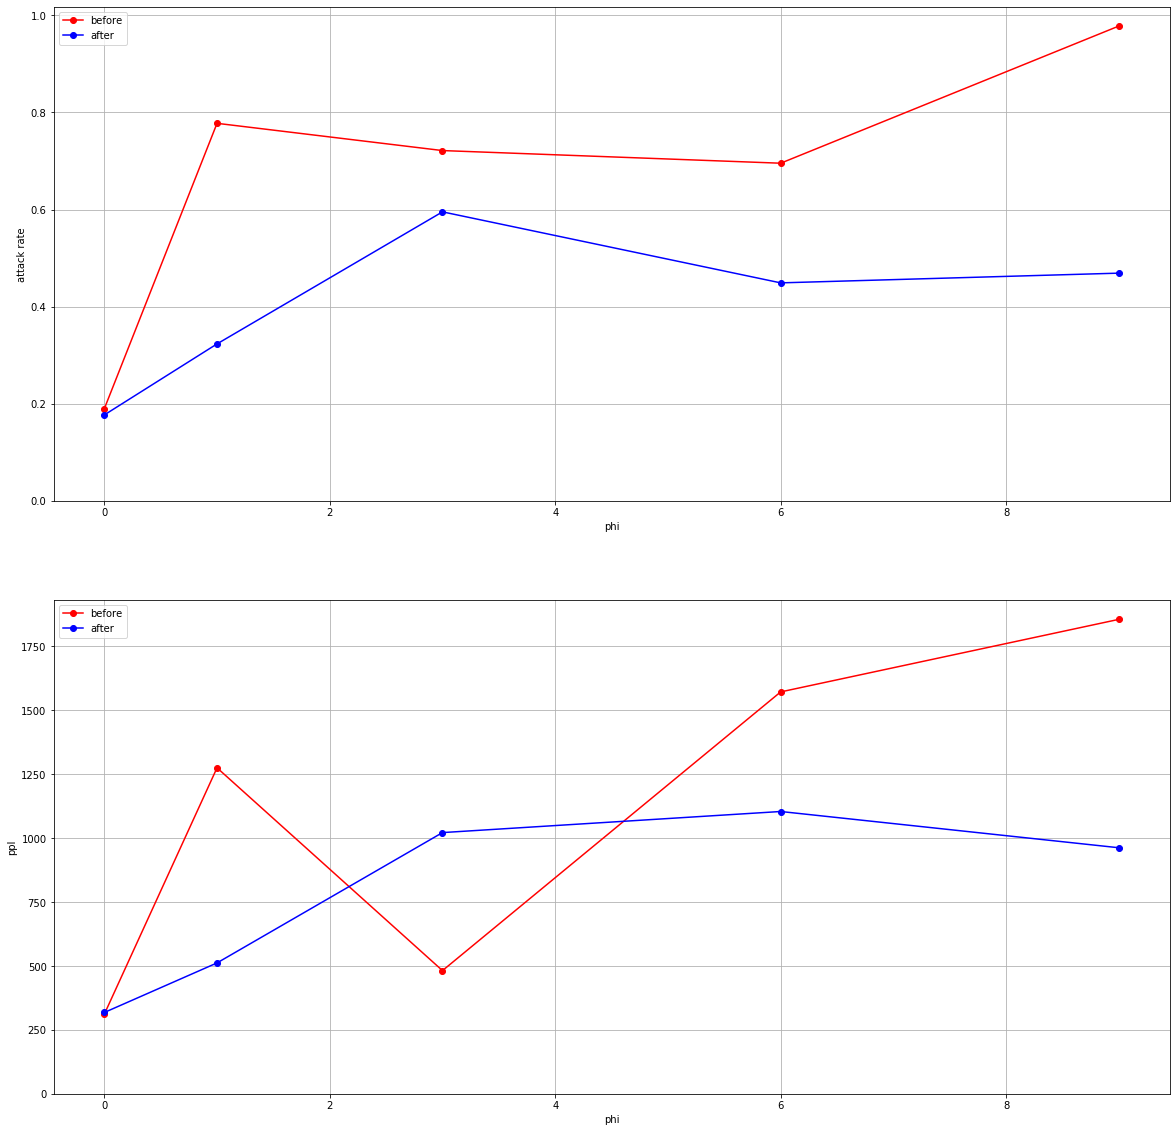

In [50]:
plot_comp_plots(phis0,at0,perp0,phis1,at1,perp1)